# Documentation
<br>
This notebook is the first step in a workflow that deals with Bradford Protein Quantification 96x well plate reader data:

1. Exploratory data analysis.
2. Cleaning the data to remove absorbance values that are outside the linear range of the instrument
3. Parsing and exporting both the calibrant and sample data into the processed_data_files directory preparatory to downstream analysis

Alex Perkins 16th November 2021
a.j.p.perkins@sms.ed.ac.uk

### Environment Preparation ---------------------------------------------------------------

### Import Packages

In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample

print(f"Running on PyMC3 v{pm.__version__}")

import arviz as az
from scipy.stats import norm

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil

from experiment_specific_config import *

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


### This cell just deals with reading the data file in the directory

In [2]:
##################################################################

move_file = False

##################################################################
# define error handler
class UnAcceptedValueError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

####################################################################
# gets all items in directory
items = os.listdir(".")

# lists all .csv
csv_list = []

try:
    for names in items:
        if names.endswith(".CSV") | names.endswith(".csv"):
            csv_list.append(names)

except:
    print("Couldn't find any csv files")

try:
    if(len(csv_list) > 1):
        raise UnAcceptedValueError("More than 1x .CSV file in the directory");
except UnAcceptedValueError as e:
    print ("Received error:", e.data)
    # kills the process
    quit()
##########################################################################################
print(csv_list)
#import dataset as dataframe
raw_data = pd.read_csv(csv_list[0], header=None)

date= raw_data.iloc[1,1]



data = raw_data.iloc[9:,:]

data.columns = data.iloc[0,:]

data = data.iloc[1:,:3]

data = data.reset_index(drop=True)


['14032022_first_RSs_bradford.csv']


In [3]:
#######################################################################

print(os.getcwd())
path = "/src/output/"
# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
# now that the dataset has been read in, move it into the output file for neatness.
if 1 == move_file:
    shutil.move(csv_list[0], path)

# navigate into the directory for future plot storage
os.chdir(path)

/src


### End of Enviroment Setup ---------------------------------------------------------------------------

In [4]:
#  define limits for linear range of platereader
upper_limit = 0.75
lower_limit = 0.45


# Looking at the raw calibrant data

## Step 1: Looking at the raw values

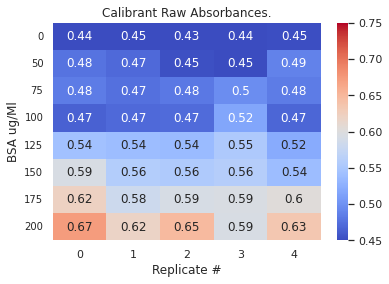

In [5]:
# real concs in wells. Stocks in ug/ml diluted by 20x
calibrant_range = ["0","50","75","100", "125", "150", "175","200"]

num_of_calibrant_wells = num_calibrant_replicates * len(calibrant_range)

calibrants = data.iloc[:num_of_calibrant_wells,[2]]


# reshape
calibrants = calibrants.astype(float)
calibrants_np = calibrants.to_numpy()

calibrants_np_2d = np.reshape(calibrants_np, (int(len(calibrants_np)/num_calibrant_replicates), num_calibrant_replicates))

import seaborn as sns

sns.set()
ax1 = sns.heatmap(calibrants_np_2d, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")
ax1.set_ylabel("BSA ug/Ml")
ax1.set_title("Calibrant Raw Absorbances.")
ax1.set_xlabel("Replicate #")
plt.yticks(np.arange(8)+0.5,calibrant_range, rotation=0, fontsize="10")

plt.savefig("BSA_absorbances_heat.png")

plt.show()

## Step 2: Reorganising Calibrant Data

In [6]:
# segregate the calibrant samples.
calibrants_df = pd.DataFrame(calibrants_np_2d, columns=["Rep1", "Rep2", "Rep3","Rep4", "Rep5"], index=calibrant_range)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


    Concentration  Absorbance
0             0.0       0.437
1             0.0       0.445
2             0.0       0.435
3             0.0       0.437
4             0.0       0.452
5            50.0       0.477
6            50.0       0.471
7            50.0       0.453
8            50.0       0.450
9            50.0       0.488
10           75.0       0.483
11           75.0       0.475
12           75.0       0.481
13           75.0       0.496
14           75.0       0.483
15          100.0       0.465
16          100.0       0.470
17          100.0       0.472
18          100.0       0.516
19          100.0       0.468
20          125.0       0.543
21          125.0       0.538
22          125.0       0.536
23          125.0       0.554
24          125.0       0.521
25          150.0       0.593
26          150.0       0.558
27          150.0       0.555
28          150.0       0.560
29          150.0       0.539
30          175.0       0.622
31          175.0       0.582
32        

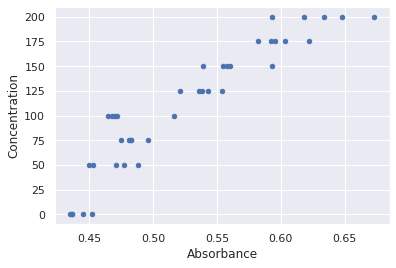

In [7]:
# define the function to use it later
def reorg_calibrants_for_GLM(input_data):
    output_for_glm = pd.DataFrame(columns=['Concentration', 'Absorbance'])
    for idx, row in input_data.iterrows():


        r_list = [row['Rep1'],row['Rep2'],row['Rep3'],row['Rep4'],row['Rep5']]

        place_holder_df = pd.DataFrame()

        place_holder_df['Absorbance'] = r_list
        place_holder_df['Concentration'] = np.float(idx)

        output_for_glm = output_for_glm.append(place_holder_df)

    output_for_glm =output_for_glm.reset_index(drop=True)
    print(output_for_glm)

    output_for_glm.plot.scatter(x='Absorbance', y='Concentration')
    
    return output_for_glm

calibrants_for_GP = reorg_calibrants_for_GLM(calibrants_df)

## Step 3: Filter the calibrants and only keep those within the linear range  (0.75 - 0.45)

In [8]:
##################   Subset Standards aborbance values that fall within the linear range (0.75 - 0.45)

calibrants_for_GP = calibrants_for_GP.loc[(calibrants_for_GP["Absorbance"] >= lower_limit) & (calibrants_for_GP["Absorbance"] <= upper_limit)]
calibrants_for_GP = calibrants_for_GP.reset_index(drop=True)
print(calibrants_for_GP)

    Concentration  Absorbance
0             0.0       0.452
1            50.0       0.477
2            50.0       0.471
3            50.0       0.453
4            50.0       0.450
5            50.0       0.488
6            75.0       0.483
7            75.0       0.475
8            75.0       0.481
9            75.0       0.496
10           75.0       0.483
11          100.0       0.465
12          100.0       0.470
13          100.0       0.472
14          100.0       0.516
15          100.0       0.468
16          125.0       0.543
17          125.0       0.538
18          125.0       0.536
19          125.0       0.554
20          125.0       0.521
21          150.0       0.593
22          150.0       0.558
23          150.0       0.555
24          150.0       0.560
25          150.0       0.539
26          175.0       0.622
27          175.0       0.582
28          175.0       0.592
29          175.0       0.595
30          175.0       0.603
31          200.0       0.673
32        

## Step: 4 Defining the absorbance of each concentration as a gaussian.

This allows us to store the mean concentration and it's error as a function and calculate the probabilities on demand.

Lets assume that the technical error of the absorbance measurements are normally distributed

1. We calculate the mean and the standard deviation for each absorbance triplicate.
2. We define a gaussian sampling function so we can easily sample and return a granular array.

In [9]:


# calculate the mean of each triplicate
calibrants_df["Mean"] = calibrants_df.mean(axis=1)
# calculate the variance of each triplicate
calibrants_df["σ"] = calibrants_df.iloc[:,:3].std(axis=1)

calibrants_df_avg = calibrants_df[["Mean", "σ"]]


def sample_gaussian(mu, sigma):
    
    # define the x range: mean - 4*sigma and mean + 4*sigma. increments = mean/1000
    x = np.arange((mu-(4*sigma)),(mu+(4*sigma)), mu/1000)
    
    # use the norm.pdf (probability density function) to sample and return the array.
    return norm.pdf(x, mu, sigma)

# do it for each calibrant. Not currently stored.
for idx, row in calibrants_df_avg.iterrows():
    sample_gaussian(calibrants_df.loc[idx]["Mean"], calibrants_df.loc[idx]["σ"])


Having got our function, lets plot all the gaussians together and have a wee look.

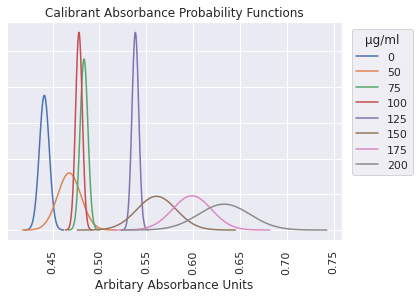

In [10]:
def print_all_gaussians(mu, sigma, bins, index):
    
    # define the x range: mean - 4*sigma and mean + 4*sigma. increments = mean/1000
    x = np.arange((mu-(4*sigma)),(mu+(4*sigma)), mu/1000)
    
    # plot the function
    plt.plot(x, norm.pdf(x, mu, sigma),  label=str(idx))
    

# do it for every calibrant and produce the plot afterwards
for idx, row in calibrants_df.iterrows():
    print_all_gaussians(calibrants_df.loc[idx]["Mean"], calibrants_df.loc[idx]["σ"], 10000, idx)

# just setting the labels and ticks
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=True)

plt.title('Calibrant Absorbance Probability Functions')
plt.xticks(rotation=90)
plt.xlabel('Arbitary Absorbance Units')

plt.legend(title='μg/ml', loc=(1.03, 0.3))

plt.savefig('Calibrant Absorbance Probabilty Functions.png')

# Sample Data

# Step 1: Looking at the raw sample data

In [11]:
dilution_data = data.iloc[num_of_calibrant_wells:,:]
dilution_data = dilution_data.reset_index(drop=True)
dilution_data['Raw Data (595)'] = pd.to_numeric(dilution_data['Raw Data (595)'])

In [12]:
dilutions

['50', '100', '250', '400', '500', '600', '750', '1000']

In [13]:
num_experiment_replicates

3

In [14]:
protein_slicer = num_experiment_replicates * len(dilutions)
protein_slicer

24

In [15]:
dilution_dict = {}

proteins_backslice = 0
proteins_frontslice = protein_slicer

for p in unknown_proteins:
    
    # initalise the upper key of the dict
    dilution_dict[p] = {}
    
    # get all of the wells relevent to that protein using the slices and reset the index
    working_slice = dilution_data.iloc[proteins_backslice:proteins_frontslice,:]
    working_slice = working_slice.reset_index(drop=True)
    
    
    #initalise the slicers for going through the dilutions
    dilutions_backslice = 0
    dilutions_frontslice = num_experiment_replicates
    
    # iterate through the dilutions list
    for d in dilutions:
        
        # actually assign the data
        dilution_dict[p][d] = working_slice.iloc[dilutions_backslice : dilutions_frontslice]
        
        # update the slicers
        dilutions_backslice = dilutions_frontslice
        dilutions_frontslice = dilutions_frontslice + num_experiment_replicates
        

    # update the slicers
    proteins_backslice = proteins_frontslice
    proteins_frontslice = proteins_frontslice + protein_slicer
    
dilution_dict


{'AA tRNA Synthetases': {'50': 9 Well     Content  Raw Data (595)
  0  A01  Sample X41           0.449
  1  A02  Sample X42           0.488
  2  A03  Sample X43           0.490,
  '100': 9 Well     Content  Raw Data (595)
  3  B01  Sample X44           0.463
  4  B02  Sample X45           0.436
  5  B03  Sample X46           0.431,
  '250': 9 Well     Content  Raw Data (595)
  6  C01  Sample X47           0.431
  7  C02  Sample X48           0.422
  8  C03  Sample X49           0.425,
  '400': 9  Well     Content  Raw Data (595)
  9   D01  Sample X50           0.431
  10  D02  Sample X51           0.427
  11  D03  Sample X52           0.422,
  '500': 9  Well     Content  Raw Data (595)
  12  E01  Sample X53           0.426
  13  E02  Sample X54           0.432
  14  E03  Sample X55           0.431,
  '600': 9  Well     Content  Raw Data (595)
  15  F01  Sample X56           0.428
  16  F02  Sample X57           0.424
  17  F03  Sample X58           0.440,
  '750': 9  Well     Content  

In [24]:
dilution_dict['AA tRNA Synthetases']['50']

9,Well,Content,Raw Data (595)
0,A01,Sample X41,0.449
1,A02,Sample X42,0.488
2,A03,Sample X43,0.490


# Make directory for sticking the heat maps into

In [25]:
print(os.getcwd())

path = "/src/output/sampleheatmaps/"

# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
   

/src/output


# Iterate through the dilution dictionary and make the plots

## Step 2: Reorganising Sample Data

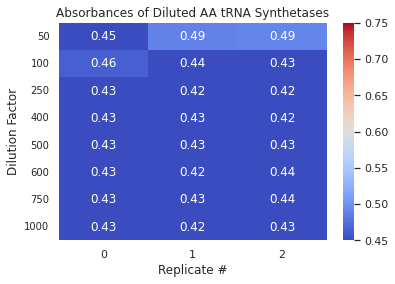

   DilutionX  Absorbance           ProteinMix
0         50       0.449  AA tRNA Synthetases
1         50       0.488  AA tRNA Synthetases
2         50       0.490  AA tRNA Synthetases
3        100       0.463  AA tRNA Synthetases
4        100       0.436  AA tRNA Synthetases
5        100       0.431  AA tRNA Synthetases
6        250       0.431  AA tRNA Synthetases
7        250       0.422  AA tRNA Synthetases
8        250       0.425  AA tRNA Synthetases
9        400       0.431  AA tRNA Synthetases
10       400       0.427  AA tRNA Synthetases
11       400       0.422  AA tRNA Synthetases
12       500       0.426  AA tRNA Synthetases
13       500       0.432  AA tRNA Synthetases
14       500       0.431  AA tRNA Synthetases
15       600       0.428  AA tRNA Synthetases
16       600       0.424  AA tRNA Synthetases
17       600       0.440  AA tRNA Synthetases
18       750       0.431  AA tRNA Synthetases
19       750       0.428  AA tRNA Synthetases
20       750       0.436  AA tRNA 

In [53]:
sns.set()

#initalise empty tidy dataframe
dilution_df = pd.DataFrame(columns= ["DilutionX", "Absorbance", "ProteinMix"])


for p_id, p_data in dilution_dict.items():
    
    # p_id is the mixture name. e.g. AA tRNA Synthatases
    # p_data contains a dictionary containing all of the dilutions. e.g. '100': dataframe with three replicates

    
    protein_list = []
    
    for dilution in p_data:
        
        # dilution is just the key. i.e. '100'
        
        # use the key to look up all the absorbance values for the replicates of that dilution.
        # make them into a list and append on the 'master list' for that protein mixture
        
        sample_data = list(p_data[dilution]['Raw Data (595)'])
        protein_list.append(sample_data)
        
    
    
    plot_dict = {}
    
    # using the index and the dilution dictionary keys, populate the plot dict with the absorbances lists generated above.
    for i,d in enumerate(dilutions):
        
        plot_dict[d] = protein_list[i]
        
    # use the dictionary to make a DataFrame and transpose it
        
    plot_df = pd.DataFrame(plot_dict).T
    
    
    # make heatmap
    
    sns.heatmap(plot_df, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")

    plt.ylabel("Dilution Factor")
    
    title = "Absorbances of Diluted " + p_id
    
    plt.title(title)
    plt.xlabel("Replicate #")
    plt.yticks(np.arange(plot_df.shape[0])+0.5, dilutions, rotation=0, fontsize="10")

    figname = p_id + "_" + dilution + ".png"

    plt.savefig(figname)
    plt.show()
    
    
    
    ######### retranspose back so that the melt works
    plot_df = plot_df.T
    
    # melt for tidy data
    melted = pd.melt(frame = plot_df,
                    var_name = 'DilutionX',
                    value_name = 'Absorbance'
                    )
    
    
    melted['ProteinMix'] = p_id
    
    dilution_df = pd.concat([dilution_df, melted])
    
    
dilution_df = dilution_df.reset_index(drop=True)
    
print(dilution_df) 

## Step 3:  Filter the sample data and only keep those within the linear range  (0.75 - 0.45)

In [54]:
##################   Subset Standards aborbance values that fall within the linear range (0.75 - 0.45)

acceptable_data = dilution_df.loc[(dilution_df["Absorbance"] >= lower_limit) & (dilution_df["Absorbance"] <= upper_limit)]

acceptable_data = acceptable_data.reset_index(drop=True)
print(acceptable_data)

  DilutionX  Absorbance           ProteinMix
0        50       0.488  AA tRNA Synthetases
1        50       0.490  AA tRNA Synthetases
2       100       0.463  AA tRNA Synthetases


# Exporting the parsed calibrant and sample data

## Step 1: Check if '/processed_data_files' exists. If not, create it and navigate inside.

In [55]:
print(os.getcwd())
path_processed_data = "/src/processed_data_files/"
# make directory for sticking the processed data in
if os.path.isdir(path_processed_data) == False:
    os.mkdir(path_processed_data, mode=0o777)

# navigate into the path_processed_data directory for data storage
os.chdir(path_processed_data)
print(os.getcwd())


/src
/src/processed_data_files


## Step 2: Export both calibrant and sample data into processed_data_files as CSV files.

In [56]:
calibrants_for_GP.to_csv("parsed_calibrant_data.csv")
acceptable_data.to_csv("tidy_sample_data.csv")

In [57]:
# navigate back into the root directory for neatness
os.chdir("/src/")

## 